In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
from networkx.algorithms import community, bipartite
from constants import stablecoins
from utils import create_graph #, plot_degree_distribution, edge_to_remove, girvan_newman

### Load Data

In [3]:
df = pd.read_csv("all_coins_data.csv")

In [4]:
#df = read_data("all_coins_data.csv")
nodes = list(set(df.coin))#Get unique list of coins
volatile_coins = [n for n in nodes if nodes not in stablecoins]
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df.to_csv("df_app_data.csv", sep=";", index = False)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversion_type,conversion_symbol,coin,daily_return_pct,intraday_return,daily_log_return,stablecoin
0,2020-08-22,0.1262,0.1183,0.1229,84207229.64,10373929.94,0.1253,direct,NaN,ADA,0.019528,0.019528,0.019340,0
1,2020-08-23,0.1259,0.1195,0.1253,64772529.12,7945897.18,0.1215,direct,NaN,ADA,-0.030327,-0.030327,-0.030797,0
2,2020-08-24,0.1270,0.1201,0.1215,77809944.45,9662533.63,0.1237,direct,NaN,ADA,0.018107,0.018107,0.017945,0
3,2020-08-25,0.1238,0.1063,0.1237,65939158.71,7699604.99,0.1126,direct,NaN,ADA,-0.089733,-0.089733,-0.094018,0
4,2020-08-26,0.1183,0.1107,0.1126,21686624.36,2483949.36,0.1144,direct,NaN,ADA,0.015986,0.015986,0.015859,0


#### Return Analysis

In [5]:
df_return_wide = df[["time", "close", "coin"]].pivot(index = "time",columns="coin", values = "close").pct_change()
df_return_wide.head()

coin,ADA,ALGO,ATOM,BCH,BNB,BSV,BTC,BUSD,CRO,CTC,...,USDT,VET,WBTC,XEM,XLM,XMR,XRP,XTZ,YFI,ZEC
time,,,,,,,,,,,,,,,,,,,,,
2020-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-23,-0.030327,0.087288,0.328351,-0.007116,-0.016652,-0.012314,-0.001619,0.000000,0.010588,-0.001601,...,0.000000,-0.021978,-0.034769,0.172109,0.006849,-0.034887,-0.004542,-0.017323,-0.110158,0.098100
2020-08-24,0.018107,0.026217,-0.038444,0.022029,0.034783,0.050796,0.009001,0.000000,0.024447,0.008821,...,0.000000,0.022472,0.009002,-0.037495,0.000972,0.026728,0.013338,0.046346,0.156500,-0.048697
2020-08-25,-0.089733,-0.108061,0.022550,-0.051532,-0.053074,-0.059519,-0.036222,0.001000,-0.035227,-0.036566,...,0.001000,-0.071429,-0.039143,0.021328,-0.054951,-0.054838,-0.041566,-0.066033,-0.065973,-0.090049
2020-08-26,0.015986,-0.021171,-0.080343,-0.003769,0.037833,-0.004744,0.012032,-0.001099,0.007656,0.012376,...,-0.000999,0.017751,0.045869,0.038675,0.007191,0.004515,-0.000723,-0.019494,0.160486,0.026280


In [6]:
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df_long = pd.melt(df, id_vars=["coin","time", "stablecoin"], value_vars=["high","low","open","volumefrom","volumeto","close","daily_return_pct","intraday_return","daily_log_return"], ignore_index=False).set_index("time")
df_long.head()

,coin,stablecoin,variable,value
time,,,,
2020-08-22,ADA,0,high,0.1262
2020-08-23,ADA,0,high,0.1259
2020-08-24,ADA,0,high,0.1270
2020-08-25,ADA,0,high,0.1238
2020-08-26,ADA,0,high,0.1183


In [7]:
#Stable coins
fig = px.line(df_long[(df_long.variable == "close") & 
(df_long.stablecoin == 0)].reset_index()[["time","coin","value"]], 
x = "time", y = "value", color = 'coin')
fig.show()


In [8]:
#Volatile coins
fig = px.line(df_long[(df_long.variable == "close") & 
(df_long.stablecoin == 1)].reset_index()[["time","coin","value"]], 
x = "time", y = "value", color = 'coin')
fig.show()


### Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

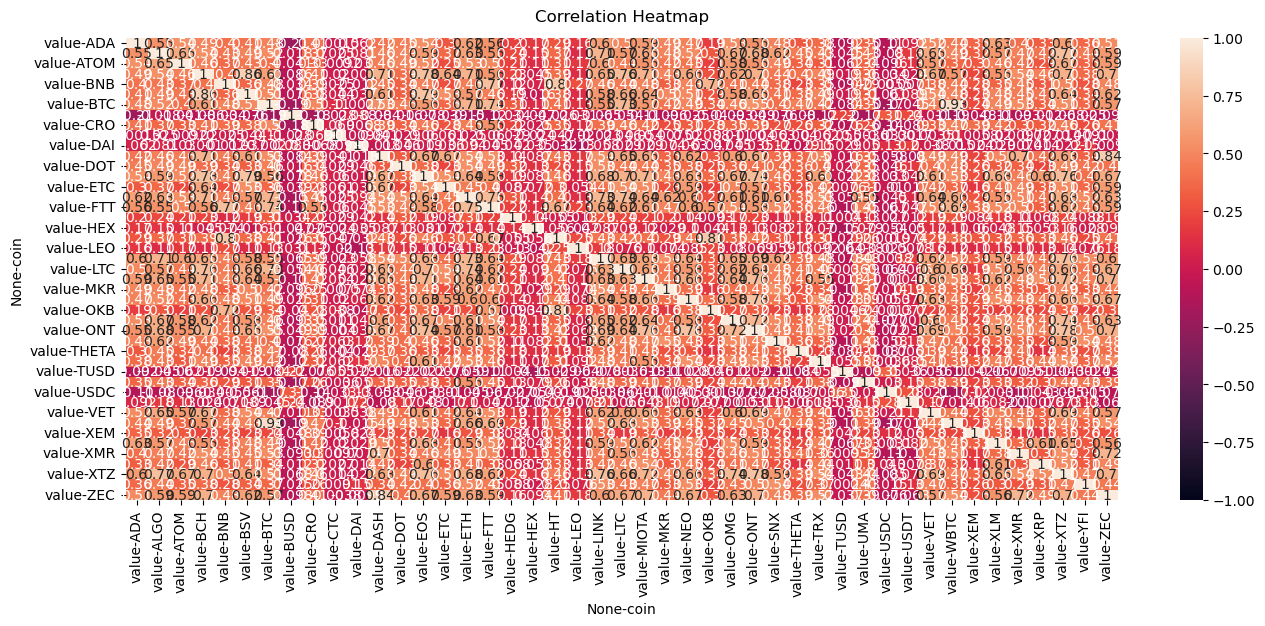

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_long[df_long["variable"]=="daily_log_return"].reset_index().drop(["variable", "stablecoin"], axis = 1).pivot(index = "time",columns="coin").corr(), 
                      vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [10]:
corr_df = df_long[df_long["variable"]=="daily_log_return"].drop(["stablecoin", "variable"], axis = 1).pivot(columns = "coin", values="value").corr()
corr_df = corr_df.unstack(level = 0).to_frame().rename(columns = {0:"corr"})
corr_df = corr_df[corr_df["corr"]!=1].reset_index(level=0).rename(columns={"coin":"cointo"}).reset_index().rename(columns = {"coin":"coinfrom"})

In [11]:
corr_df

,coinfrom,cointo,corr
0,ALGO,ADA,0.553742
1,ATOM,ADA,0.544778
2,BCH,ADA,0.487691
3,BNB,ADA,0.402013
4,BSV,ADA,0.407859
...,...,...,...
1975,XLM,ZEC,0.558968
1976,XMR,ZEC,0.719137
1977,XRP,ZEC,0.486107
1978,XTZ,ZEC,0.701012


count    1980.000000
mean        0.309292
std         0.240525
min        -0.207258
25%         0.081984
50%         0.344697
75%         0.490242
max         0.932428
Name: corr, dtype: float64

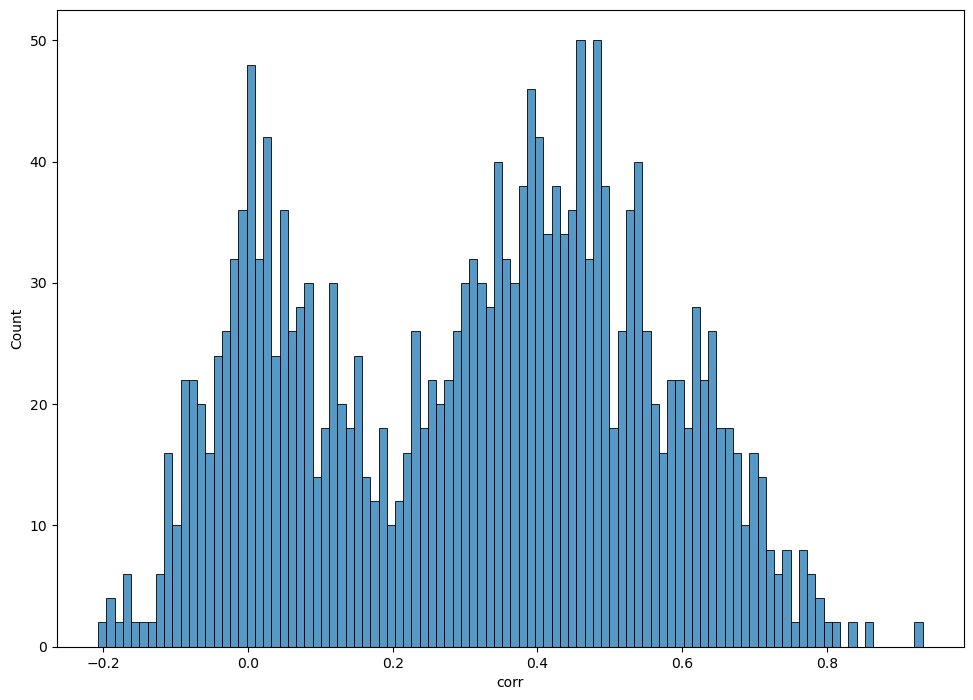

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.histplot(corr_df, x = "corr", bins = 100)
corr_df["corr"].describe()

In [13]:
# Create a range for all correlations
corr_range = []
corr_range.append(corr_df["corr"].min())
while corr_range[-1]<corr_df["corr"].max():
    corr_range.append(corr_range[-1]+0.01)
corr_range.append(corr_df["corr"].max())

#### Graph charts

#### MST

In [14]:
corr_df = corr_df[corr_df["corr"]>=0.2]

### Create network

In [15]:
G = create_graph(corr_df, stablecoins, volatile_coins)

#### MST

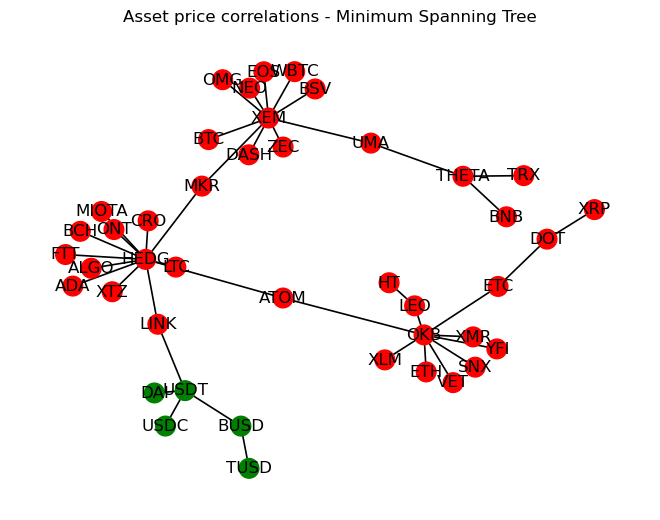

In [16]:
mst = nx.minimum_spanning_tree(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]
nx.draw(mst, with_labels=True, pos=nx.fruchterman_reingold_layout(mst),
        node_size=200, node_color  = color_map, width = 1.2)

plt.title("Asset price correlations - Minimum Spanning Tree")
plt.show()

### Find correlation treshold

/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



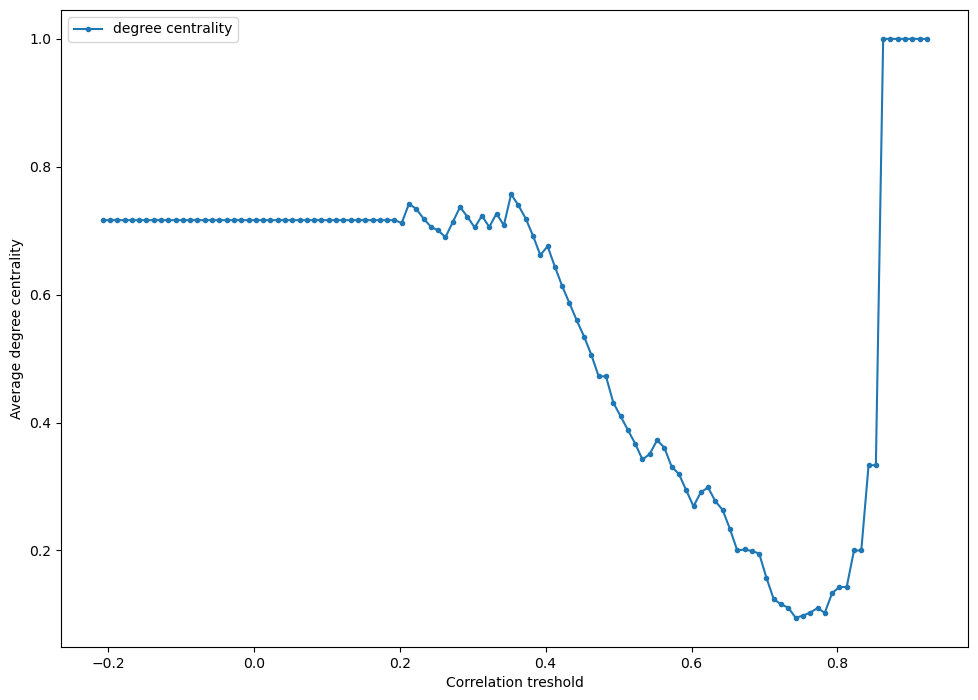

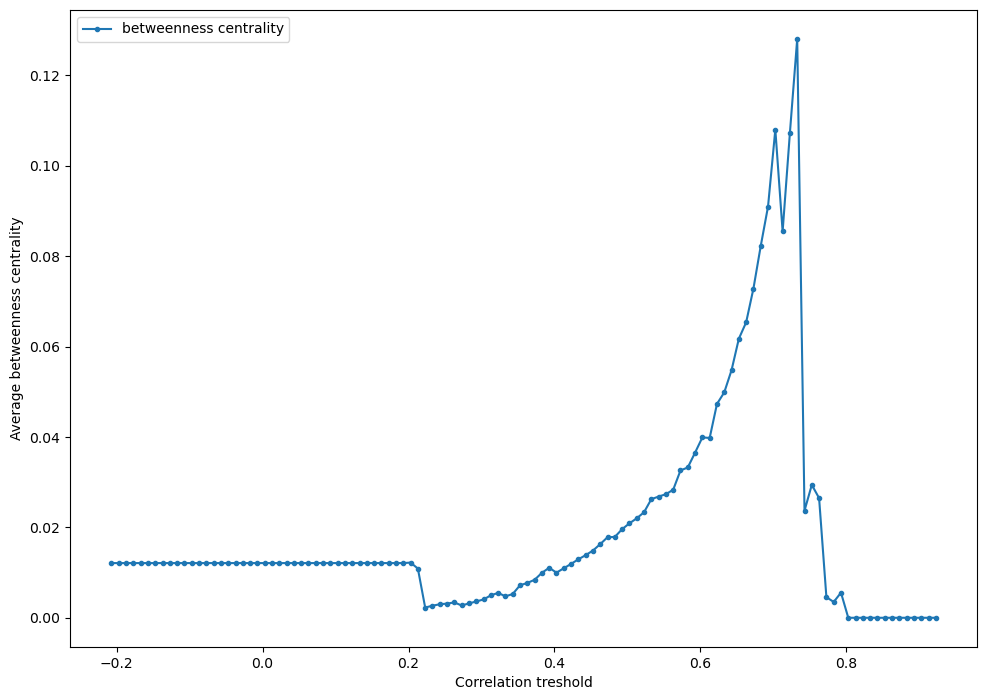

NetworkXPointlessConcept: cannot compute centrality for the null graph

In [59]:
centrality_functions = {
    'degree centrality': nx.degree_centrality,
    'betweenness centrality': nx.betweenness_centrality,
    'eigenvector centrality': nx.eigenvector_centrality,
    'closeness centrality': nx.closeness_centrality
    }

for f_name, f in centrality_functions.items():
    mean_values = []
    for c in corr_range:
        G = create_graph(corr_df[corr_df["corr"] > c], stablecoins, volatile_coins)
        mean_values.append(np.mean(list(f(G).values())))
    plt.figure(figsize=a4_dims)
    plt.plot(corr_range, mean_values, '.-', label = f_name)
    plt.xlabel('Correlation treshold')
    plt.ylabel('Average %s' % f_name)
    plt.legend()
    plt.show()

#### MST with treshold

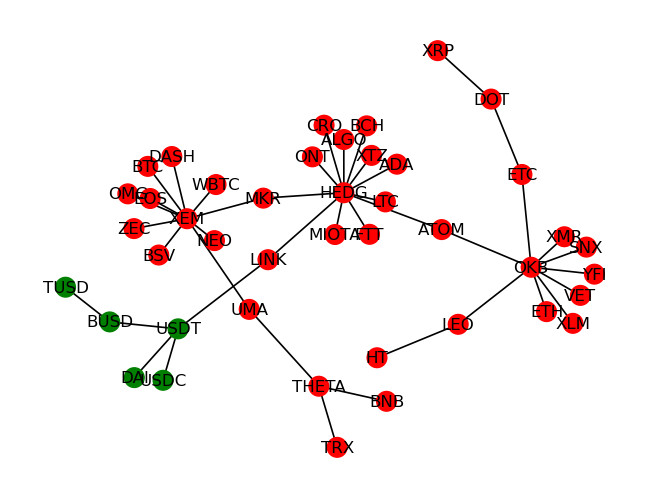

In [21]:
G = create_graph(corr_df[corr_df["corr"] >= 0.2], stablecoins, volatile_coins)
mst = nx.minimum_spanning_tree(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]


nx.draw(mst, with_labels=True, pos=nx.fruchterman_reingold_layout(mst),
        node_size=200, node_color = color_map, width = 1.2)

plt.savefig("images/mst.png", format="PNG")
plt.show()


#### Community detection

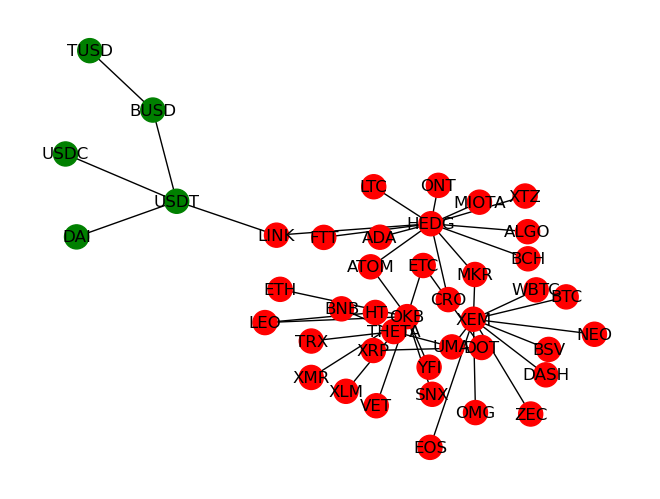

In [22]:
communities = community.louvain_communities(mst)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))

pos= nx.kamada_kawai_layout(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]

nx.draw(mst, with_labels=True, node_color = color_map, pos = pos)
plt.savefig("images/community_louvain.png", format="PNG")
plt.show()

Girvan Newman

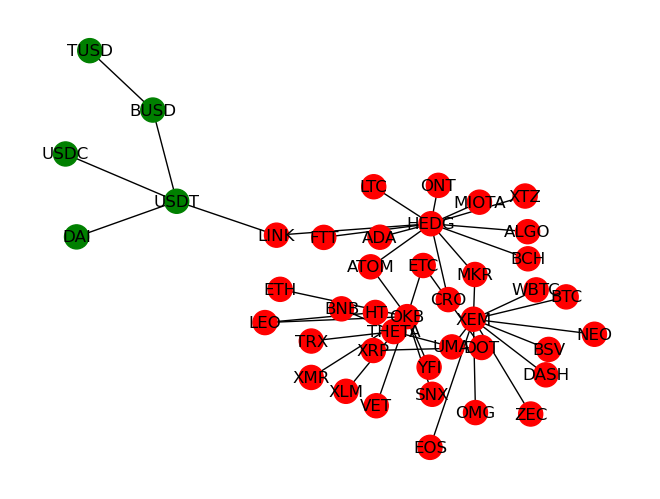

In [23]:
communities = community.girvan_newman(mst)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]

pos= nx.kamada_kawai_layout(G)
nx.draw(mst,  with_labels=True, node_color = color_map, pos = pos)
plt.savefig("images/community_gn.png", format="PNG")
plt.show()

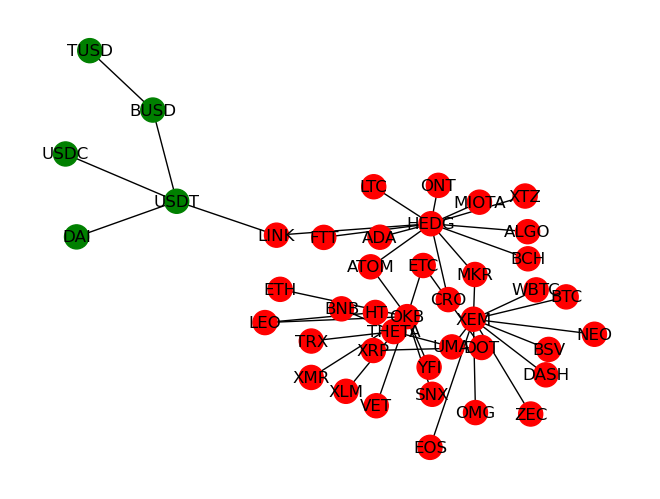

In [27]:
communities = community.k_clique_communities(mst, 2)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]

pos= nx.kamada_kawai_layout(G)
nx.draw(mst,  with_labels=True, node_color = color_map, pos = pos)
plt.savefig("images/community_kclique.png", format="PNG")
plt.show()